In [49]:
# Imports using Sklearn make shortcut functions
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Imports
import os
from google.cloud import bigquery

In [50]:
data = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/1988_to_2024_combined_clean_polling_and_results.csv')

In [51]:
# # Environment variables
# gcp_project_id = os.environ['GCP_PROJECT']
# gcp_service_account_key = os.environ['GCP_SERVICE_ACCOUNT_KEY']
# bq_source_dataset = os.environ['BQ_SOURCE_DATASET']
# bq_cleaned_dataset = os.environ['BQ_CLEANED_DATASET']

In [52]:
# # Environment variables
# gcp_project_id = os.environ['GCP_PROJECT']
# gcp_service_account_key = os.environ['GCP_SERVICE_ACCOUNT_KEY']

# # Import data from BQ and set data to X
# # Initialize a BigQuery client using the service account JSON file
# bq_client = bigquery.Client(project=gcp_project_id).from_service_account_json(gcp_service_account_key)

# # SQL query
# query = f"""
#     SELECT *
#     FROM `{gcp_project_id}.master_sources.national_polls_results_combined`
#     """
# # Use BQ client to create DF from the selected table
# data = bq_client.query(query).to_dataframe()


In [53]:
# data.rename(columns={'int64_field_0':'startdate'},inplace=True)

In [54]:
# # Import data from BQ and set data to X
# # Initialize a BigQuery client using the service account JSON file
# bq_client = bigquery.Client(project=gcp_project_id).from_service_account_json(gcp_service_account_key)

# # Setting the table we want from the source dataset
# select_table = 'cleaned_full_polls_combined_national_results_2004_2019'

# # SQL query for querying Big Query and fetching entire table
# query = f"""
#     SELECT *
#     FROM `{gcp_project_id}.{bq_cleaned_dataset}.{select_table}`
# """

In [55]:
# # Use BQ client to create DF from the selected table
# data = bq_client.query(query).to_dataframe()

In [56]:
# # Replace any found NaN values with 0
data.replace(np.nan, 0, inplace=True)

# # Add a field 'poll length' that shows number of days the poll was held for
# data['poll_length'] = pd.to_datetime(data.enddate) - pd.to_datetime(data.startdate)
# data['poll_length'] = data['poll_length'].dt.days

# # Divide forecasts by 100 to create values between 0-1
# # for column in ['BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC', 'UKI_FC']:
# #     data[column] = data[column] / 100

# #     # Divide actuals by 100 to create values between 0-1
# # for column in ['BRX_ACT', 'CON_ACT', 'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE']:
# #     data[column] = data[column] / 100

# data.sort_values('enddate', inplace=True)

# data.reset_index(inplace=True)

In [95]:
data.dtypes

Unnamed: 0                        int64
startdate                        object
enddate                          object
pollster                         object
samplesize                        int64
rating                           object
next_elec_date                   object
days_to_elec                      int64
months_to_elec                    int64
months_to_elec_weight           float64
poll_length                       int64
party_in_power                   object
CON_FC                          float64
LAB_FC                          float64
LIB_FC                          float64
BRX_FC                          float64
GRE_FC                          float64
OTH_FC                          float64
PLC_FC                          float64
SNP_FC                          float64
UKI_FC                          float64
CON_ACT                         float64
LAB_ACT                         float64
LIB_ACT                         float64
BRX_ACT                         float64


In [57]:
# Load Trends csvs from raw_data folder
trends1 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_CON_LIB_GRE_BRX_Trends_2004_now.csv')
trends2 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_PLC_SNP_UKI_NAT_Trends_2004_now.csv')

In [58]:
# Drop duplicate Labour column
trends2.drop(columns='Labour Party: (United Kingdom)',inplace=True)

In [59]:
# Join two trends datasets on 'Month'
trends_merged = pd.merge(trends1,trends2,how='left',on='Month')

In [60]:
trends_merged['Month'] = pd.to_datetime(trends_merged['Month'])

In [61]:
# Replace <1 values with 0.5 value
trends_merged.replace('<1', 0.5,inplace=True)

In [62]:
# Converting objects (pd.Series) to int dtypes
trends_merged = trends_merged.astype({'Green Party: (United Kingdom)':'int','Reform UK: (United Kingdom)':'int',\
    'Plaid Cymru: (United Kingdom)':'int','Scottish National Party: (United Kingdom)':'int',\
        'UK Independence Party: (United Kingdom)':'int','British National Party: (United Kingdom)':'int'})

In [63]:
# Rename columns to align them more easily with _FC and _ACT columns
trends_merged.rename(columns={'Labour Party: (United Kingdom)': 'LAB_trends',
        'Conservative Party: (United Kingdom)': 'CON_trends',
        'Liberal Democrats: (United Kingdom)': 'LIB_trends',
        'Green Party: (United Kingdom)': 'GRE_trends',
        'Reform UK: (United Kingdom)': 'BRX_trends',
        'Plaid Cymru: (United Kingdom)': 'PLC_trends',
        'Scottish National Party: (United Kingdom)': 'SNP_trends',
        'UK Independence Party: (United Kingdom)': 'UKI_trends',
        'British National Party: (United Kingdom)': 'NAT_trends'}
        ,inplace=True)

In [64]:
# trends_merged.to_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/national_google_trends_master.csv')

In [65]:
# Loading ONS csv files
ons_gdp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_gdp_2004_2024.csv')
ons_inf = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_inflation_2004_2024.csv')
ons_emp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_unemployment_2004_2024.csv')

In [66]:
# Replacing spaces with - for GDP df
ons_gdp.Quarter = ons_gdp.Quarter.str.replace(' ', '-')

# Turning quarters into months for GDP df
ons_gdp.Quarter = pd.PeriodIndex(ons_gdp.Quarter, freq='Q').to_timestamp()

# Fill missing months and impute with quarterly values per month for GDP df
ons_gdp = ons_gdp.set_index('Quarter').resample('MS').ffill()
ons_gdp.index.names = ['Month']

In [67]:
# Convert months into pd.DateTime and set as index
ons_inf.Month = pd.to_datetime(ons_inf.Month)
ons_inf = ons_inf.set_index('Month')

ons_emp.Month = pd.to_datetime(ons_emp.Month)
ons_emp = ons_emp.set_index('Month')

/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_24323/3454880804.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_inf.Month = pd.to_datetime(ons_inf.Month)
/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_24323/3454880804.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_emp.Month = pd.to_datetime(ons_emp.Month)


In [68]:
# Merging GDP, Inflation and Unemployment dfs into ons_merged
ons_merged = pd.merge(ons_gdp,pd.merge(ons_inf,ons_emp,how='left',on='Month'),how='outer',on='Month')

# Filling NaNs with previous value of column
ons_merged = ons_merged.ffill()

In [69]:
# ons_merged.to_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_economic_data_master.csv')

In [70]:
ons_merged.head()

,GDP,Inflation,Unemployment
Month,,,
2004-01-01,322790.0,1.5,4.8
2004-02-01,322790.0,1.4,4.8
2004-03-01,322790.0,1.2,4.8
2004-04-01,329664.0,1.1,4.8
2004-05-01,329664.0,1.4,4.8


In [71]:
# Create poll enddate field with YYYY-MM format, so we can join with Trends data
data['enddate_year_month'] = pd.to_datetime(data['enddate']).dt.to_period('M')

In [72]:
# Convert Period datatype to str and then to datetime64
data.enddate_year_month = pd.to_datetime(data.enddate_year_month.astype('str'))

In [73]:
# Merge data with trends data, to get a df with polls, election results and trends
data_trends = pd.merge(data,trends_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [74]:
# Merge data with ONS data, to get a df with polls, election results, trends and ONS data
data_trends_ons = pd.merge(data_trends,ons_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [75]:
# Scale trends columns by diving by 100
for column in ['LAB_trends', 'CON_trends', 'LIB_trends',
       'GRE_trends', 'BRX_trends', 'PLC_trends', 'SNP_trends', 'UKI_trends',
       'NAT_trends']:
    data_trends_ons[column] = data_trends_ons[column] / 100

In [76]:
# Drop columns we don't need
data_trends_ons = data_trends_ons.drop(columns=['startdate', 'enddate', 'pollster'])

In [96]:
data_trends_ons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5672 entries, 0 to 5671
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             5672 non-null   int64         
 1   samplesize             5672 non-null   int64         
 2   rating                 5672 non-null   object        
 3   next_elec_date         5672 non-null   datetime64[ns]
 4   days_to_elec           5672 non-null   int64         
 5   months_to_elec         5672 non-null   int64         
 6   months_to_elec_weight  5672 non-null   float64       
 7   poll_length            5672 non-null   int64         
 8   party_in_power         5672 non-null   object        
 9   CON_FC                 5672 non-null   float64       
 10  LAB_FC                 5672 non-null   float64       
 11  LIB_FC                 5672 non-null   float64       
 12  BRX_FC                 5672 non-null   float64       
 13  GRE

In [97]:
data_trends_ons['CON_GAP'] = data_trends_ons['CON_ACT'] - data_trends_ons['CON_FC']
data_trends_ons['LAB_GAP'] = data_trends_ons['LAB_ACT'] - data_trends_ons['LAB_FC']
data_trends_ons['LIB_GAP'] = data_trends_ons['LIB_ACT'] - data_trends_ons['LIB_FC']
data_trends_ons['GRE_GAP'] = data_trends_ons['GRE_ACT'] - data_trends_ons['GRE_FC']
data_trends_ons['BRX_GAP'] = data_trends_ons['BRX_ACT'] - data_trends_ons['BRX_FC']
data_trends_ons['SNP_GAP'] = data_trends_ons['SNP_ACT'] - data_trends_ons['SNP_FC']
data_trends_ons['UKI_GAP'] = data_trends_ons['UKI_ACT'] - data_trends_ons['UKI_FC']
data_trends_ons['PLC_GAP'] = data_trends_ons['PLC_ACT'] - data_trends_ons['PLC_FC']
data_trends_ons['OTH_GAP'] = data_trends_ons['OTH_PERCENTAGE'] - data_trends_ons['OTH_FC']

In [98]:
data_trends_ons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5672 entries, 0 to 5671
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             5672 non-null   int64         
 1   samplesize             5672 non-null   int64         
 2   rating                 5672 non-null   object        
 3   next_elec_date         5672 non-null   datetime64[ns]
 4   days_to_elec           5672 non-null   int64         
 5   months_to_elec         5672 non-null   int64         
 6   months_to_elec_weight  5672 non-null   float64       
 7   poll_length            5672 non-null   int64         
 8   party_in_power         5672 non-null   object        
 9   CON_FC                 5672 non-null   float64       
 10  LAB_FC                 5672 non-null   float64       
 11  LIB_FC                 5672 non-null   float64       
 12  BRX_FC                 5672 non-null   float64       
 13  GRE

In [79]:
from datetime import datetime
# Split data up to 2017 election (TRAIN) and all data related to 2019 election (TEST)
data_trends_ons['next_elec_date'] = data_trends_ons['next_elec_date'].astype("datetime64[ns]")
data_train = data_trends_ons[data_trends_ons['next_elec_date'] < datetime.strptime('2019-12-12', '%Y-%m-%d')]
data_train = data_train[data_train['next_elec_date'] >= datetime.strptime('2005-05-05', '%Y-%m-%d')]
data_test = data_trends_ons[data_trends_ons['next_elec_date'] == datetime.strptime('2019-12-12', '%Y-%m-%d')]

In [106]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2866 entries, 1004 to 3869
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             2866 non-null   int64         
 1   samplesize             2866 non-null   int64         
 2   rating                 2866 non-null   object        
 3   next_elec_date         2866 non-null   datetime64[ns]
 4   days_to_elec           2866 non-null   int64         
 5   months_to_elec         2866 non-null   int64         
 6   months_to_elec_weight  2866 non-null   float64       
 7   poll_length            2866 non-null   int64         
 8   party_in_power         2866 non-null   object        
 9   CON_FC                 2866 non-null   float64       
 10  LAB_FC                 2866 non-null   float64       
 11  LIB_FC                 2866 non-null   float64       
 12  BRX_FC                 2866 non-null   float64       
 13  GRE_F

In [99]:
# Handle numerical transformer
num_columns_selector = ['samplesize', 'days_to_elec', 'poll_length','GDP','Inflation','Unemployment','months_to_elec','months_to_elec_weight']
num_transformer = MinMaxScaler()

In [100]:
# Handle categorical transformer
cat_columns_selector = ['rating']
cat_transformer = make_pipeline(OrdinalEncoder(categories = [['F','F+','E-','E','E+','D-','D','D+','C-','C','C+','B-','B','B+','A-']]),MinMaxScaler())

# One-hot encoder for party_in_power
ohe = OneHotEncoder()

In [101]:
# Build the preprocessing pipeline
preproc_pipeline = make_column_transformer(
    (num_transformer, num_columns_selector),
    (cat_transformer, cat_columns_selector),
    (ohe,['party_in_power']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [105]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2866 entries, 1004 to 3869
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             2866 non-null   int64         
 1   samplesize             2866 non-null   int64         
 2   rating                 2866 non-null   object        
 3   next_elec_date         2866 non-null   datetime64[ns]
 4   days_to_elec           2866 non-null   int64         
 5   months_to_elec         2866 non-null   int64         
 6   months_to_elec_weight  2866 non-null   float64       
 7   poll_length            2866 non-null   int64         
 8   party_in_power         2866 non-null   object        
 9   CON_FC                 2866 non-null   float64       
 10  LAB_FC                 2866 non-null   float64       
 11  LIB_FC                 2866 non-null   float64       
 12  BRX_FC                 2866 non-null   float64       
 13  GRE_F

In [102]:
# Fit transform preprocessing pipeline to data_train
data_train_processed = preproc_pipeline.fit_transform(data_train)

# Transform preprocessing pipeline to data_test
data_test_processed = preproc_pipeline.transform(data_test)

In [103]:
# Check feature names make sense for data_train
data_train_processed = pd.DataFrame(
    data_train_processed, columns=preproc_pipeline.get_feature_names_out()
)

# Check feature names make sense for data_test
data_test_processed = pd.DataFrame(
    data_test_processed, columns=preproc_pipeline.get_feature_names_out()
)

In [104]:
data_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   samplesize                   2866 non-null   object        
 1   days_to_elec                 2866 non-null   object        
 2   poll_length                  2866 non-null   object        
 3   GDP                          2818 non-null   object        
 4   Inflation                    2818 non-null   object        
 5   Unemployment                 2818 non-null   object        
 6   months_to_elec               2866 non-null   object        
 7   months_to_elec_weight        2866 non-null   object        
 8   rating                       2866 non-null   object        
 9   party_in_power_Conservative  2866 non-null   object        
 10  party_in_power_Labour        2866 non-null   object        
 11  Unnamed: 0                   2866 non-null 

In [86]:
# # Define our X by dropping irrelevant and y columns

# X_train = data_train_processed.drop(columns=['index','days_to_elec','next_elec_date', 'BRX_ACT', 'CON_ACT',
#        'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
#        'OTH_PERCENTAGE','enddate_year_month','Month'])

# X_test = data_test_processed.drop(columns=['index','days_to_elec','next_elec_date', 'BRX_ACT', 'CON_ACT',
#        'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
#        'OTH_PERCENTAGE','enddate_year_month','Month'])

In [182]:
X_train_LAB = data_train_processed[['LAB_FC','months_to_elec_weight','Inflation','LAB_trends']]
X_train_CON = data_train_processed[['CON_FC','months_to_elec_weight']]
X_train_LIB = data_train_processed[['LIB_FC','months_to_elec_weight']]
X_train_GRE = data_train_processed[['GRE_FC','months_to_elec_weight']]
X_train_BRX = data_train_processed[['BRX_FC','months_to_elec_weight']]
X_train_SNP = data_train_processed[['SNP_FC','months_to_elec_weight']]
X_train_UKI = data_train_processed[['UKI_FC','months_to_elec_weight']]
X_train_PLC = data_train_processed[['PLC_FC','months_to_elec_weight']]
X_train_OTH = data_train_processed[['OTH_FC','months_to_elec_weight']]

X_test_LAB = data_test_processed[['LAB_FC','months_to_elec_weight','Inflation','LAB_trends']]
X_test_CON = data_test_processed[['CON_FC','months_to_elec_weight']]
X_test_LIB = data_test_processed[['LIB_FC','months_to_elec_weight']]
X_test_GRE = data_test_processed[['GRE_FC','months_to_elec_weight']]
X_test_BRX = data_test_processed[['BRX_FC','months_to_elec_weight']]
X_test_SNP = data_test_processed[['SNP_FC','months_to_elec_weight']]
X_test_UKI = data_test_processed[['UKI_FC','months_to_elec_weight']]
X_test_PLC = data_test_processed[['PLC_FC','months_to_elec_weight']]
X_test_OTH = data_test_processed[['OTH_FC','months_to_elec_weight']]

In [183]:
# # Build our target matrix, retaining each party share vote columns only
# y_train = data_train_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
#                     'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

# # Build our target matrix, retaining each party share vote columns only
# y_test = data_test_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
#                     'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

In [184]:
# #TODO – refactor the below into a function > model instantiation, fitting, scoring, etc.
# # Handle target extraction for test and train sets respectively
# #TODO Kwarg > defaults to either cross val or prediction
y_train_LAB = y_train['LAB_ACT']
y_train_CON = y_train['CON_ACT']
y_train_LIB = y_train['LIB_ACT']
y_train_GRE = y_train['GRE_ACT']
y_train_BRX = y_train['BRX_ACT']
y_train_SNP = y_train['SNP_ACT']
y_train_UKI = y_train['UKI_ACT']
y_train_PLC = y_train['PLC_ACT']
y_train_OTH = y_train['OTH_PERCENTAGE']

y_test_LAB = y_test['LAB_ACT']
y_test_CON = y_test['CON_ACT']
y_test_LIB = y_test['LIB_ACT']
y_test_GRE = y_test['GRE_ACT']
y_test_BRX = y_test['BRX_ACT']
y_test_SNP = y_test['SNP_ACT']
y_test_UKI = y_test['UKI_ACT']
y_test_PLC = y_test['PLC_ACT']
y_test_OTH = y_test['OTH_PERCENTAGE']

In [185]:
y_train_gap_LAB = data_train_processed['LAB_GAP']
y_train_gap_CON = data_train_processed['CON_GAP']
y_train_gap_LIB = data_train_processed['LIB_GAP']
y_train_gap_GRE = data_train_processed['GRE_GAP']
y_train_gap_BRX = data_train_processed['BRX_GAP']
y_train_gap_SNP = data_train_processed['SNP_GAP']
y_train_gap_UKI = data_train_processed['UKI_GAP']
y_train_gap_PLC = data_train_processed['PLC_GAP']
y_train_gap_OTH = data_train_processed['OTH_GAP']

y_test_gap_LAB = data_test_processed['LAB_GAP']
y_test_gap_CON = data_test_processed['CON_GAP']
y_test_gap_LIB = data_test_processed['LIB_GAP']
y_test_gap_GRE = data_test_processed['GRE_GAP']
y_test_gap_BRX = data_test_processed['BRX_GAP']
y_test_gap_SNP = data_test_processed['SNP_GAP']
y_test_gap_UKI = data_test_processed['UKI_GAP']
y_test_gap_PLC = data_test_processed['PLC_GAP']
y_test_gap_OTH = data_test_processed['OTH_GAP']

In [186]:
# # Instantiate the model for each party
model_LAB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_CON = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_LIB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_GRE = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_BRX = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_SNP = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_UKI = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_PLC = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_OTH = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)

In [187]:
# # # Handle model training
# # X_train_matrix = np.array(X_train)

# model_LAB.fit(np.array(X_train_LAB), y_train_LAB)
# model_CON.fit(np.array(X_train_CON), y_train_CON)
# model_LIB.fit(np.array(X_train_LIB), y_train_LIB)
# model_GRE.fit(np.array(X_train_GRE), y_train_GRE)
# model_BRX.fit(np.array(X_train_BRX), y_train_BRX)
# model_SNP.fit(np.array(X_train_SNP), y_train_SNP)
# model_UKI.fit(np.array(X_train_UKI), y_train_UKI)
# model_PLC.fit(np.array(X_train_PLC), y_train_PLC)
# model_OTH.fit(np.array(X_train_OTH), y_train_OTH)

In [188]:
# # Handle model training
# X_train_matrix = np.array(X_train)

model_LAB.fit(np.array(X_train_LAB), y_train_gap_LAB)
model_CON.fit(np.array(X_train_CON), y_train_gap_CON)
model_LIB.fit(np.array(X_train_LIB), y_train_gap_LIB)
model_GRE.fit(np.array(X_train_GRE), y_train_gap_GRE)
model_BRX.fit(np.array(X_train_BRX), y_train_gap_BRX)
model_SNP.fit(np.array(X_train_SNP), y_train_gap_SNP)
model_UKI.fit(np.array(X_train_UKI), y_train_gap_UKI)
model_PLC.fit(np.array(X_train_PLC), y_train_gap_PLC)
model_OTH.fit(np.array(X_train_OTH), y_train_gap_OTH)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [189]:
# # Evaluate model performance with cross validation
# # X_test_matrix = np.array(X_test)

# y_pred_LAB = model_LAB.predict(np.array(X_test_LAB))
# y_pred_CON = model_CON.predict(np.array(X_test_CON))
# y_pred_LIB = model_LIB.predict(np.array(X_test_LIB))
# y_pred_GRE = model_GRE.predict(np.array(X_test_GRE))
# y_pred_BRX = model_BRX.predict(np.array(X_test_BRX))
# y_pred_SNP = model_SNP.predict(np.array(X_test_SNP))
# y_pred_UKI = model_UKI.predict(np.array(X_test_UKI))
# y_pred_PLC = model_PLC.predict(np.array(X_test_PLC))
# y_pred_OTH = model_OTH.predict(np.array(X_test_OTH))

In [190]:
# # Evaluate model performance with cross validation
# X_test_matrix = np.array(X_test)

y_pred_gap_LAB = model_LAB.predict(np.array(X_test_LAB))
y_pred_gap_CON = model_CON.predict(np.array(X_test_CON))
y_pred_gap_LIB = model_LIB.predict(np.array(X_test_LIB))
y_pred_gap_GRE = model_GRE.predict(np.array(X_test_GRE))
y_pred_gap_BRX = model_BRX.predict(np.array(X_test_BRX))
y_pred_gap_SNP = model_SNP.predict(np.array(X_test_SNP))
y_pred_gap_UKI = model_UKI.predict(np.array(X_test_UKI))
y_pred_gap_PLC = model_PLC.predict(np.array(X_test_PLC))
y_pred_gap_OTH = model_OTH.predict(np.array(X_test_OTH))

In [191]:
y_test_gap_LAB = data_test['LAB_FC'] - y_pred_gap_LAB

In [192]:
# print(f"2019 prediction for LAB: {y_pred_LAB.mean()}")
# print(f"2019 prediction for CON: {y_pred_CON.mean()}")
# print(f"2019 prediction for LIB: {y_pred_LIB.mean()}")
# print(f"2019 prediction for GRE: {y_pred_GRE.mean()}")
# print(f"2019 prediction for BRX: {y_pred_BRX.mean()}")
# print(f"2019 prediction for SNP: {y_pred_SNP.mean()}")
# print(f"2019 prediction for UKI: {y_pred_UKI.mean()}")
# print(f"2019 prediction for PLC: {y_pred_PLC.mean()}")
# print(f"2019 prediction for OTH: {y_pred_OTH.mean()}")

In [193]:
print(f"2019 prediction for LAB: {y_pred_gap_LAB.mean()}")
print(f"2019 prediction for CON: {y_pred_gap_CON.mean()}")
print(f"2019 prediction for LIB: {y_pred_gap_LIB.mean()}")
print(f"2019 prediction for GRE: {y_pred_gap_GRE.mean()}")
print(f"2019 prediction for BRX: {y_pred_gap_BRX.mean()}")
print(f"2019 prediction for SNP: {y_pred_gap_SNP.mean()}")
print(f"2019 prediction for UKI: {y_pred_gap_UKI.mean()}")
print(f"2019 prediction for PLC: {y_pred_gap_PLC.mean()}")
print(f"2019 prediction for OTH: {y_pred_gap_OTH.mean()}")

2019 prediction for LAB: 0.013408051803708076
2019 prediction for CON: 0.008925741538405418
2019 prediction for LIB: 0.005491449497640133
2019 prediction for GRE: -0.009464442729949951
2019 prediction for BRX: 0.0
2019 prediction for SNP: -0.006571343634277582
2019 prediction for UKI: 0.026850983500480652
2019 prediction for PLC: 0.0057561988942325115
2019 prediction for OTH: 0.0201654564589262


In [194]:
# print(f"2019 prediction for LAB: {y_pred_LAB[-30:-1].mean()}")
# print(f"2019 prediction for CON: {y_pred_CON[-30:-1].mean()}")
# print(f"2019 prediction for LIB: {y_pred_LIB[-30:-1].mean()}")
# print(f"2019 prediction for GRE: {y_pred_GRE[-30:-1].mean()}")
# print(f"2019 prediction for BRX: {y_pred_BRX[-30:-1].mean()}")
# print(f"2019 prediction for SNP: {y_pred_SNP[-30:-1].mean()}")
# print(f"2019 prediction for UKI: {y_pred_UKI[-30:-1].mean()}")
# print(f"2019 prediction for PLC: {y_pred_PLC[-30:-1].mean()}")
# print(f"2019 prediction for OTH: {y_pred_OTH[-30:-1].mean()}")

In [195]:
print(f"2019 prediction for LAB: {y_pred_gap_LAB[-30:-1].mean()}")
print(f"2019 prediction for CON: {y_pred_gap_CON[-30:-1].mean()}")
print(f"2019 prediction for LIB: {y_pred_gap_LIB[-30:-1].mean()}")
print(f"2019 prediction for GRE: {y_pred_gap_GRE[-30:-1].mean()}")
print(f"2019 prediction for BRX: {y_pred_gap_BRX[-30:-1].mean()}")
print(f"2019 prediction for SNP: {y_pred_gap_SNP[-30:-1].mean()}")
print(f"2019 prediction for UKI: {y_pred_gap_UKI[-30:-1].mean()}")
print(f"2019 prediction for PLC: {y_pred_gap_PLC[-30:-1].mean()}")
print(f"2019 prediction for OTH: {y_pred_gap_OTH[-30:-1].mean()}")

2019 prediction for LAB: 0.03989609703421593
2019 prediction for CON: -0.0047575728967785835
2019 prediction for LIB: -0.03594866394996643
2019 prediction for GRE: -0.004800459835678339
2019 prediction for BRX: 0.0
2019 prediction for SNP: -0.004034831654280424
2019 prediction for UKI: 0.029569165781140327
2019 prediction for PLC: 0.005662321113049984
2019 prediction for OTH: 0.01587587781250477


In [196]:
print(y_test_gap_LAB[-5:])
print(data_test['LAB_FC'][-5:])
print(data_test['LAB_ACT'][-5:].mean())

4310    0.284516
4311    0.284687
4312    0.284516
4313    0.303165
4314    0.303165
Name: LAB_FC, dtype: float64
4310    0.33
4311    0.32
4312    0.33
4313    0.34
4314    0.34
Name: LAB_FC, dtype: float64
0.3208087238795938


In [197]:
print(y_test_gap_LAB[-100:].mean())
print(data_test['LAB_FC'][-100:].mean())

0.21625918826162815
0.29669999999999996


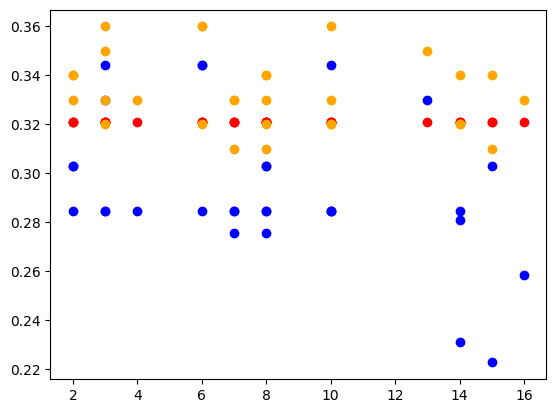

In [198]:
# plt.scatter(y=y_pred_gap_LAB[-30:],x=data_test['days_to_elec'][-30:],c='r')
plt.scatter(y=y_test_LAB[-30:],x=data_test['days_to_elec'][-30:],c='r')
plt.scatter(y=y_test_gap_LAB[-30:],x=data_test['days_to_elec'][-30:],c='b');
plt.scatter(y=data_test['LAB_FC'][-30:],x=data_test['days_to_elec'][-30:],c='orange');

In [130]:
y_test_gap_LAB[-30:].mean()

0.3220605961359922

### Code below is to test neural network

In [47]:
# # Converting data to floats for NN
# X_train_matrix_nn = X_train_matrix.astype('float')
# X_test_matrix_nn = X_test_matrix.astype('float')


# y_train_LAB_nn = y_train_LAB.astype('float')

# y_test_LAB_nn = y_test_LAB.astype('float')

In [48]:
# # Initialising Dense NN model

# def initialize_model():

#     model = models.Sequential()

#     model.add(layers.Dense(20, input_dim=X_train_matrix.shape[1], activation='relu'))  # /!\ Input size is equal to number of features
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dense(1, activation='linear')) # /!\ Trying to predict continuous variable (regression task)

#     return model

In [49]:
# # Compile model using adam optimiser and MSE as loss function

# def compile_model(model, optimizer_name):
#     model.compile(loss='mse', optimizer=optimizer_name, metrics=['mse'])
#     return model

In [50]:
# model = initialize_model()
# compile_model(model,'adam')
# es = EarlyStopping(patience=5, restore_best_weights=True)

# history = model.fit(X_train_matrix_nn, y_train_LAB_nn,
#           batch_size=16,
#           epochs=1000,
#           callbacks=[es])

# results = model.evaluate(X_test_matrix_nn,y_test_LAB_nn)

In [51]:
# y_pred_LAB_nn = model.predict(X_test_matrix_nn)

In [52]:
# print(y_pred_LAB_nn[-1])

#### Investigating features for collinearity and feature permutation

poll_length
16560    9
17323    8
14733    7
18240    7
18144    6
        ..
15243    1
15242    1
15241    1
15239    1
15736    1
Name: count, Length: 2426, dtype: int64

In [53]:
data_trends_ons[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']].describe()

,LAB_ACT,CON_ACT,LIB_ACT,GRE_ACT,BRX_ACT,SNP_ACT,UKI_ACT,PLC_ACT,OTH_PERCENTAGE
count,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000
mean,0.312252,0.379589,0.112554,0.027979,0.002717,0.038891,0.082386,0.005649,0.037983
std,0.027525,0.027846,0.058790,0.011052,0.006878,0.012097,0.053833,0.000421,0.009334
min,0.289896,0.323596,0.073654,0.008934,0.000000,0.015186,0.000713,0.004788,0.032733
25%,0.304506,0.368110,0.078705,0.015909,0.000000,0.030356,0.030986,0.005571,0.032733
50%,0.304506,0.368110,0.078705,0.036210,0.000000,0.047382,0.126435,0.005919,0.032733
75%,0.304506,0.368110,0.115477,0.036210,0.000000,0.047382,0.126435,0.005919,0.036837
max,0.399893,0.436317,0.230289,0.036210,0.020127,0.047382,0.126435,0.006440,0.057233


In [59]:
data_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   samplesize                   440 non-null    object        
 1   days_to_elec                 440 non-null    object        
 2   poll_length                  440 non-null    object        
 3   GDP                          440 non-null    object        
 4   Inflation                    440 non-null    object        
 5   Unemployment                 440 non-null    object        
 6   months_to_elec_weight        440 non-null    object        
 7   rating                       440 non-null    object        
 8   party_in_power_Conservative  440 non-null    object        
 9   party_in_power_Labour        440 non-null    object        
 10  index                        440 non-null    object        
 11  next_elec_date               440 non-null    

<Axes: >

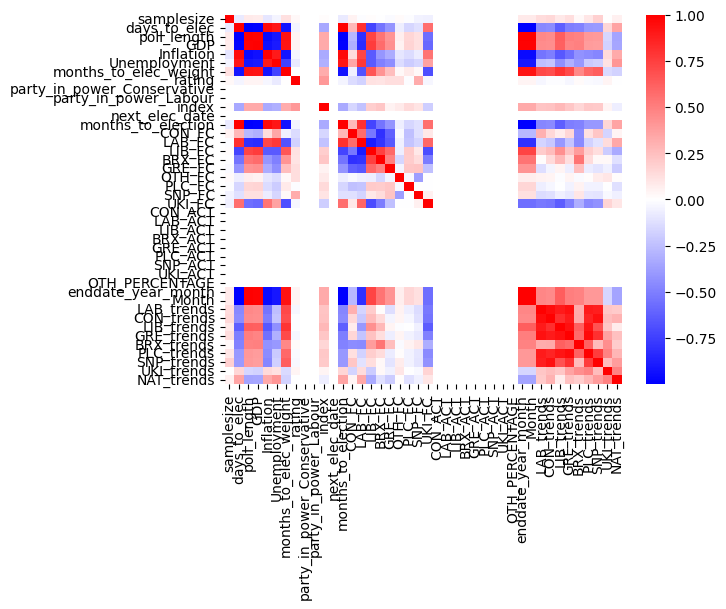

In [54]:
# Heatmap of pairwise correlations
correlation_matrix = data_test_processed.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr")

In [55]:
# Convert the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Rename the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [56]:
# Compute the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showe the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(30)

,feature_1,feature_2,correlation,absolute_correlation
590,enddate_year_month,Month,1.000000,1.000000
619,Month,enddate_year_month,1.000000,1.000000
289,months_to_election,enddate_year_month,-0.999997,0.999997
609,Month,months_to_election,-0.999997,0.999997
579,enddate_year_month,months_to_election,-0.999997,0.999997
290,months_to_election,Month,-0.999997,0.999997
61,poll_length,days_to_elec,-0.999982,0.999982
32,days_to_elec,poll_length,-0.999982,0.999982
80,poll_length,Month,0.999538,0.999538
602,Month,poll_length,0.999538,0.999538


In [57]:
# Perform the permutation
permutation_score = permutation_importance(model_LAB, np.array(X_train_onlyFC), y_train_LAB, n_repeats=10)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train_onlyFC.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
1,months_to_elec_weight,2.175341
3,Inflation,1.996654
2,party_in_power_Conservative,1.051221
0,LAB_FC,0.315538
